<a href="https://colab.research.google.com/github/heosooyoun/LLM/blob/main/chapter_3_5_%ED%9B%88%EB%A0%A8_%EA%B0%80%EB%8A%A5%ED%95%9C_%EA%B0%80%EC%A4%91%EC%B9%98%EB%A5%BC_%EA%B0%80%EC%A7%84_%EC%85%80%ED%94%84_%EC%96%B4%ED%85%90%EC%85%98_%EA%B5%AC%ED%98%84%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3.4 훈련 가능한 가중치를 가진 셀프 어텐션 구현하기


#### 3.4.1 단계별로 어텐션 가중치 계산하기

- 특정 입력 원소에 대한 입력 벡터의 가중치 합으로 문맥 벡터를 계산합니다.
- 쿼리벡터, 키벡터, 벨류 벡터를 입력 임베딩을 그대로 사용하지 않고 가중치를 곱해서 사용

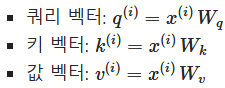

In [3]:
import torch

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

x_2 = inputs[1] # 두 번째 입력 원소
d_in = inputs.shape[1] # 입력 임베딩 크기, d=3
d_out = 2 # 출력 임베딩 크기, d=2

torch.manual_seed(123)

#3x2 행렬 쿼리, 키, 벨류 벡터 만들기
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key   = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

# 각 벡터 계산

query_2 = x_2 @ W_query # 두 번째 입력 원소에 대한 값을 계산하므로 _2로 씁니다.
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value

print(query_2)

tensor([0.4306, 1.4551])


In [4]:
# inputs 전체에 적용
keys = inputs @ W_key
values = inputs @ W_value

print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


In [6]:
# 쿼리 벡터와 키 값을 곱해서 어텐션 점수 계산
keys_2 = keys[1] # 파이썬 인덱스는 0부터 시작합니다.
attn_score_22 = query_2.dot(keys_2)
print(attn_score_22)

attn_scores_2 = query_2 @ keys.T # 주어진 쿼리에 대한 모든 어텐션 점수
print(attn_scores_2)

tensor(1.8524)
tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


이전과 차이점은 임베딩 차원의 제곱근image.png (즉, d_k**0.5)로 나누어 어텐션 점수의 스케일을 조정하는 것입니다.

In [7]:
#소프트맥스 함수를 이용해 정규화
d_k = keys.shape[1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
print(attn_weights_2)

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


In [8]:
#어텐션 가중치와 벨류 벡터를 곱한 뒤 모두 더해서 문맥 벡터를 만든다
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.3061, 0.8210])


#### 3.4.2 셀프 어텐션 파이썬 클래스 구현하기

- 지금까지 한 것들을 모두 합쳐서 셀프 어텐션 메커니즘을 구현한다

In [9]:
import torch.nn as nn

class SelfAttention_v1(nn.Module):

  def __init__(self, d_in, d_out):
     super().__init__()
     self.W_query = nn.Parameter(torch.rand(d_in, d_out))
     self.W_key = nn.Parameter(torch.rand(d_in, d_out))
     self.W_value = nn.Parameter(torch.rand(d_in, d_out))

  def forward(self, x):
    keys = x @ self.W_key
    queries = x @ self.W_query
    values = x @ self.W_value

    attn_scores = queries @ keys.T
    attn_weights = torch.softmax(
        attn_scores / keys.shape[-1]**0.5, dim =-1
    )

    context_vec = attn_weights @ values
    return context_vec

torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


- 이 구현을 행렬 곱셈과 동등한 연산을 수행하는 편향 유닛이 없는 파이토치 Linear 층을 사용해 간소화할 수 있습니다.
- nn.Parameter(torch.rand(...) 대신에 nn.Linear를 사용하는 또 다른 큰 장점은 안정적으로 모델을 훈련하는데 도움이 되는 가중치 초기화를 제공한다는 것입니다.

In [11]:
class SelfAttention_v2(nn.Module):

    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        context_vec = attn_weights @ values
        return context_vec

torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


### 3.5 코잘 어텐션으로 미래의 단어 감추기

- 마스크드 셀프 어텐션이라고도 부름
- 주 대각선 위쪽을 0으로 마스킹
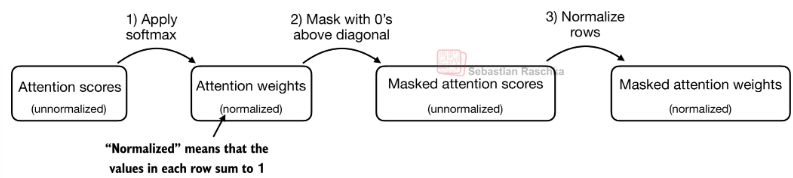



In [12]:
# 편의상 이전 절에서 만든 SelfAttention_v2 객체의 쿼리와 키 가중치 행렬을 재사용합니다.
queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs)
attn_scores = queries @ keys.T

attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


- 파이토치의 tril 함수 사용 시 주 대각선과 그 아래 함수는 1, 주대각선 위의 원소는 0인 마스크를 만들 수 있음

In [14]:
context_length = attn_scores.shape[0]
#6x6 행렬을 만든 뒤 tril 적용
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(mask_simple)

# 어텐션 가중치와 마스크를 곱해주면 주대각선 위의 어텐션 점수를 0으로 만들 수 있음
masked_simple = attn_weights*mask_simple
print(masked_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])
tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)


In [ ]:
# 소프트맥스 이후에 마스킹을 하면 숫자가 틀어지기 때문에 재정규화 필요
row_sums = masked_simple.sum(dim=-1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print(masked_simple_norm)

- 마스킹 위치를 음의 무한대로 바꿔버리면 소프트맥스 함수 적용하면 음의 무한대에 지수 함수를 씌우기 때문에 자동으로 0이 된다
-> 0 대신 음의 무한대로 마스킹하면 더 효율적임

In [17]:
mask

tensor([[0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0.]])

In [16]:
#triu함수: 상삼각행렬 만들기
#torch.one을 이용해 6x6 행렬 만들고, 윗 부분 원소만 1로 반환받고 나머진 0
#diagonal=1 -> 주 대각선 포함하지 않음
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
#masked_fill: mask.bool() 값이 false인 것은 두고 true인 것을
#두번째 매개변수 값으로 바꿈
# 주대각선 위의 원소들이 1이니까 그 부분을 음의 무한으로 바
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


In [18]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


#### 3.5.2 드롭아웃으로 어텐션 가중치에 추가적으로 마스킹하기

- 드롭아웃 비율 0.5(50%)를 적용하면 드롭아웃되지 않은 값은 1/0.5=2배 만큼 크기가 증가
- 스케일 조정 배율은 1 / (1 - dropout_rate)와 같이 계산합니다.


In [20]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5) # 50% 드롭아웃 비율
example = torch.ones(6, 6) # 1로 채워진 행렬을 만듭니다.

print(dropout(example))

# 어텐션 가중치에 적
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2., 2., 0., 2., 2., 0.],
        [0., 0., 0., 2., 0., 2.],
        [2., 2., 2., 2., 0., 2.],
        [0., 2., 2., 0., 0., 2.],
        [0., 2., 0., 2., 0., 2.],
        [0., 2., 2., 2., 2., 0.]])
tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7599, 0.6194, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4921, 0.4925, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3966, 0.0000, 0.3775, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.3331, 0.3084, 0.3331, 0.0000]],
       grad_fn=<MulBackward0>)


#### 3.5.3 코잘 어텐션 클래스 구현하기

In [21]:
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape)
# 각각 여섯 개의 토큰으로 구성된 두 개의 입력. 각 토큰의 임베딩 차원은 3입니다.


torch.Size([2, 6, 3])


In [22]:
class CausalAttention(nn.Module):
  def __init__ (self, d_in, d_out, context_length,
               dropout, qkv_bias=False):
    super().__init__()
    #self.d_out = d_out
    self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    self.dropout = nn.Dropout(dropout)
    # register_buffer에 마스킹 행렬을 저장
    # 이 클래스가 gpu, cpu로 이동할 때 같이 이동함
    # 이렇게 하면 장치가 달라졌을 때 텐서 간의 연산 오류 방지
    self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

  def forward(self, x):
    # b: 배치 차원, 토큰 갯수, 토큰의 입력 차원을 변수에 저장
    # num_tokens(입력 토큰 갯수)는 항상 context_length보다 작음
    b, num_tokens, d_in = x.shape
    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)

    attn_scores = queries @ keys.transpose(1,2) # 키 행렬을 전치
    attn_scores.masked_fill_(
        #_이 붙은 이유는 attn_scores 객체에 바로 결과가 반영되도록 한것
        #_ : 인플레이션 연산

        #입력 토큰 크기가 context_length보다 작을 수 있기 때문에
        #고려해서 행렬의 일부분을 잘라 attns_scores에 적용한
        self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
    attn_weights = torch.softmax(
        attn_scores / keys.shape[-1]**0.5, dim=-1
    )
    attn_weights = self.dropout(attn_weights)

    context_vec = attn_weights @ values
    return context_vec

torch.manual_seed(123)

context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0) #입력차원, 출력차원, 문맥 길이

context_vecs = ca(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)


tensor([[[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]],

        [[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]]], grad_fn=<UnsafeViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


- 드롭아웃은 훈련 과정에만 적용되며 추론시에는 적용되지 않습니다.